# Tuning curves: 4 cardinal directions, pooled across tasks

Common conditions: 0°, 90°, 180°, 270° (cardinal only).  
Common epochs: cue (0–500 ms), delay (500–1700 ms).  
Neurons pooled across ODR 1.5s, ODR 3.0s, and ODRd.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0, '.')

from functions import (
    load_odr_data, load_odrd_data, extract_metadata,
    assign_age_groups, pooled_tuning_by_group, pca_reduce_tuning,
    tuning_to_matrix, plot_3d_representation, wall_projections,
)
from functions.load_data import _abs_age_months

DATA_DIR = '../data_raw'

# Age group edges (absolute age in months): young / middle / old
AGE_EDGES = (48, 60)
AGE_GROUP_LABELS = ['young', 'middle', 'old']

CARDINAL_COLS = [0, 2, 4, 6]  # indices into ODR 8-direction data
COMMON_EPOCHS = {'cue': (0, 500), 'delay': (500, 1700)}
BIN_MS = 25
N_PCS = 4
MIN_NEURONS = N_PCS + 1

## 1. Load data (cardinal directions only)

In [2]:
# ODR data (8 directions) -> select 4 cardinal
odr_all, ws_odr = load_odr_data(os.path.join(DATA_DIR, 'odr_data_both_sig_is_best_20240109.mat'))
ids_all, age_all, mature_all, delay_all = extract_metadata(ws_odr, odr_all.shape[0])

# ODRd raw data (already 4 cardinal directions, not split by distractor)
odrd_raw, ws_odrd = load_odrd_data(os.path.join(DATA_DIR, 'odrd_data_sig_on_best_20231018.mat'))
odrd_ids, odrd_age, odrd_mat, _ = extract_metadata(ws_odrd, odrd_raw.shape[0])

# Build task dict with cardinal-only conditions
cardinal_data = {}
for delay, name in [(1.5, 'ODR 1.5s'), (3.0, 'ODR 3.0s')]:
    mask = delay_all == delay
    cardinal_data[name] = dict(
        data=odr_all[mask][:, CARDINAL_COLS],
        ids=ids_all[mask],
        abs_age=_abs_age_months(age_all[mask], mature_all[mask]),
    )

cardinal_data['ODRd'] = dict(
    data=odrd_raw,
    ids=odrd_ids,
    abs_age=_abs_age_months(odrd_age, odrd_mat),
)

for name, td in cardinal_data.items():
    print(f'{name}: {td["data"].shape[0]} neurons, {td["data"].shape[1]} conditions, '
          f'monkeys: {sorted(set(td["ids"]))}')

ODR 1.5s: 1180 neurons, 4 conditions, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('QUA'), np.str_('ROS'), np.str_('SON'), np.str_('TRI'), np.str_('UNI'), np.str_('VIK')]
ODR 3.0s: 922 neurons, 4 conditions, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]
ODRd: 1319 neurons, 4 conditions, monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]


## 2. Compute pooled tuning curves

In [3]:
grouped, epoch_names = pooled_tuning_by_group(
    cardinal_data, COMMON_EPOCHS, AGE_EDGES, bin_ms=BIN_MS)

print(f'Epochs: {epoch_names}')
print(f'Monkeys: {list(grouped.keys())}\n')
for mid, groups in grouped.items():
    for g, tc in groups.items():
        print(f'  {mid} / {AGE_GROUP_LABELS[g]}: {tc.shape[0]} neurons, '
              f'shape {tc.shape}')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
Epochs: ['cue', 'delay']
Monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('QUA'), np.str_('ROS'), np.str_('SON'), np.str_('TRI'), np.str_('UNI'), np.str_('VIK')]

  OLI / young: 20 neurons, shape (20, 4, 2)
  OLI / middle: 224 neurons, shape (224, 4, 2)
  OLI / old: 334 neurons, shape (334, 4, 2)
  PIC / young: 40 neurons, shape (40, 4, 2)
  PIC / middle: 248 neurons, shape (248, 4, 2)
  PIC / old: 240 neurons, shape (240, 4, 2)
  QUA / middle: 56 neurons, shape (56, 4, 2)
  ROS / young: 84 neurons, shape (84, 4, 2)
  ROS / middle: 132 neurons, shape (132, 4, 2)
  ROS / old: 256 neurons, shape (256, 4, 2)
  SON / young: 62 neurons, shape (62, 4, 2)
  SON / middle: 194 neurons, shape (194, 4, 2)
  SON / old: 74 neurons, shape (74, 4, 2)
  TRI / young: 49 neurons, shape (49, 4, 2)
  TRI / middle: 105 neurons, shape (105, 4, 2)
  TRI / old: 103 neurons

## 3. PCA-reduce tuning curves

In [4]:
reduced = pca_reduce_tuning(grouped, n_pcs=N_PCS, min_neurons=MIN_NEURONS)

for mid, groups in reduced.items():
    for g, info in groups.items():
        print(f'{mid} / {AGE_GROUP_LABELS[g]}: {info["n_neurons"]} neurons -> '
              f'{info["tc"].shape} (PCs x conds x epochs), '
              f'var explained {info["var_explained"]:.1%}')

OLI / young: 20 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 85.6%
OLI / middle: 214 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 74.4%
OLI / old: 334 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 74.7%
PIC / young: 35 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 75.1%
PIC / middle: 248 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 76.4%
PIC / old: 228 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 71.8%
QUA / middle: 56 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 75.5%
ROS / young: 82 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 76.1%
ROS / middle: 132 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 70.7%
ROS / old: 256 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 72.3%
SON / young: 62 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 79.1%
SON / middle: 194 neurons -> (4, 4, 2) (PCs x conds x epochs), var explained 70.5%
SON / old: 74 neurons 

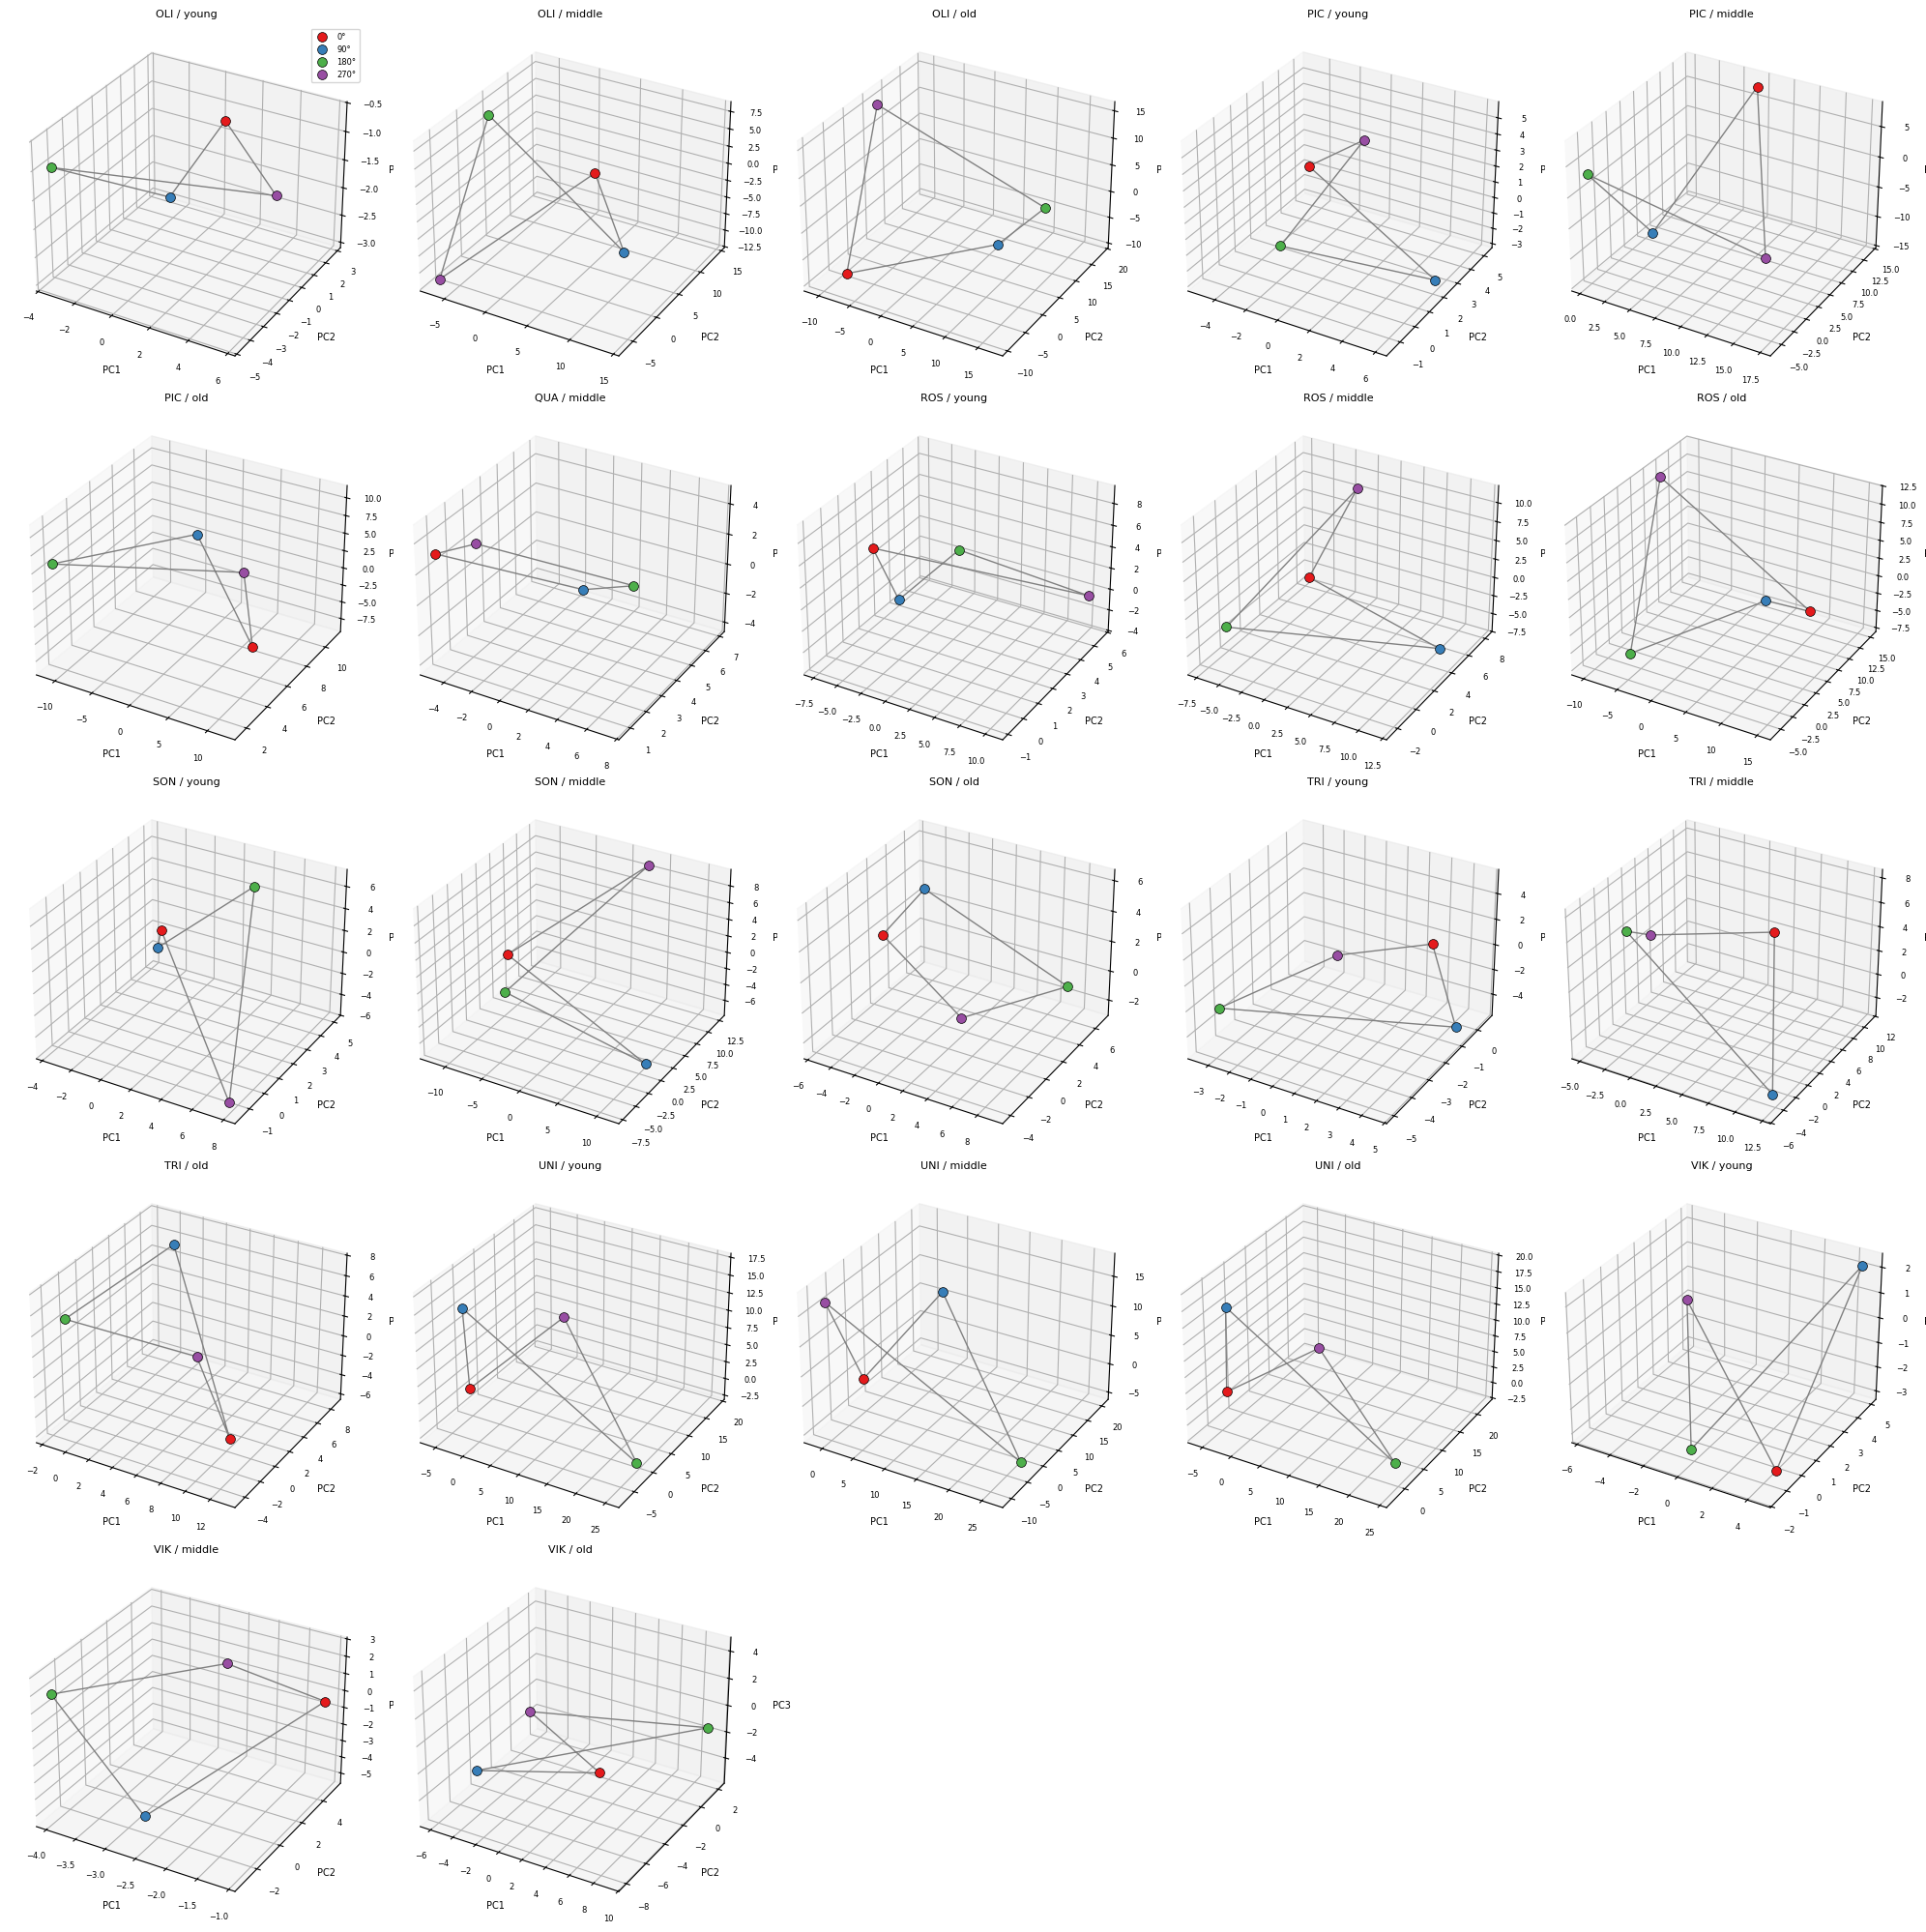

In [5]:
from mpl_toolkits.mplot3d import Axes3D

STIM_LABELS = ['0°', '90°', '180°', '270°']
STIM_COLORS = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

n_plots = sum(len(g) for g in reduced.values())
ncols = min(n_plots, 5)
nrows = int(np.ceil(n_plots / ncols))
fig = plt.figure(figsize=(4 * ncols, 4 * nrows))

i = 1
for mid, groups in reduced.items():
    for g, info in groups.items():
        ax = fig.add_subplot(nrows, ncols, i, projection='3d')
        tc = info['tc']  # (n_pcs, 4, 2)
        x = tc[0, :, 0]  # PC1
        y = tc[1, :, 0]  # PC2
        z = tc[2, :, 0]  # PC3

        # Connect consecutive stimuli (circular)
        x_loop = np.append(x, x[0])
        y_loop = np.append(y, y[0])
        z_loop = np.append(z, z[0])
        ax.plot(x_loop, y_loop, z_loop, '-', color='gray', lw=1, zorder=1)

        # Color dots by stimulus
        for s in range(4):
            ax.scatter(x[s], y[s], z[s], color=STIM_COLORS[s], s=50, zorder=2,
                       edgecolors='k', linewidths=0.5, label=STIM_LABELS[s])

        ax.set_title(f'{mid} / {AGE_GROUP_LABELS[g]}', fontsize=8)
        ax.set_xlabel('PC1', fontsize=7)
        ax.set_ylabel('PC2', fontsize=7)
        ax.set_zlabel('PC3', fontsize=7)
        ax.tick_params(labelsize=6)
        if i == 1:
            ax.legend(fontsize=6, loc='best')
        i += 1

plt.tight_layout()

## 4. Within-monkey alignment (age groups aligned per monkey)

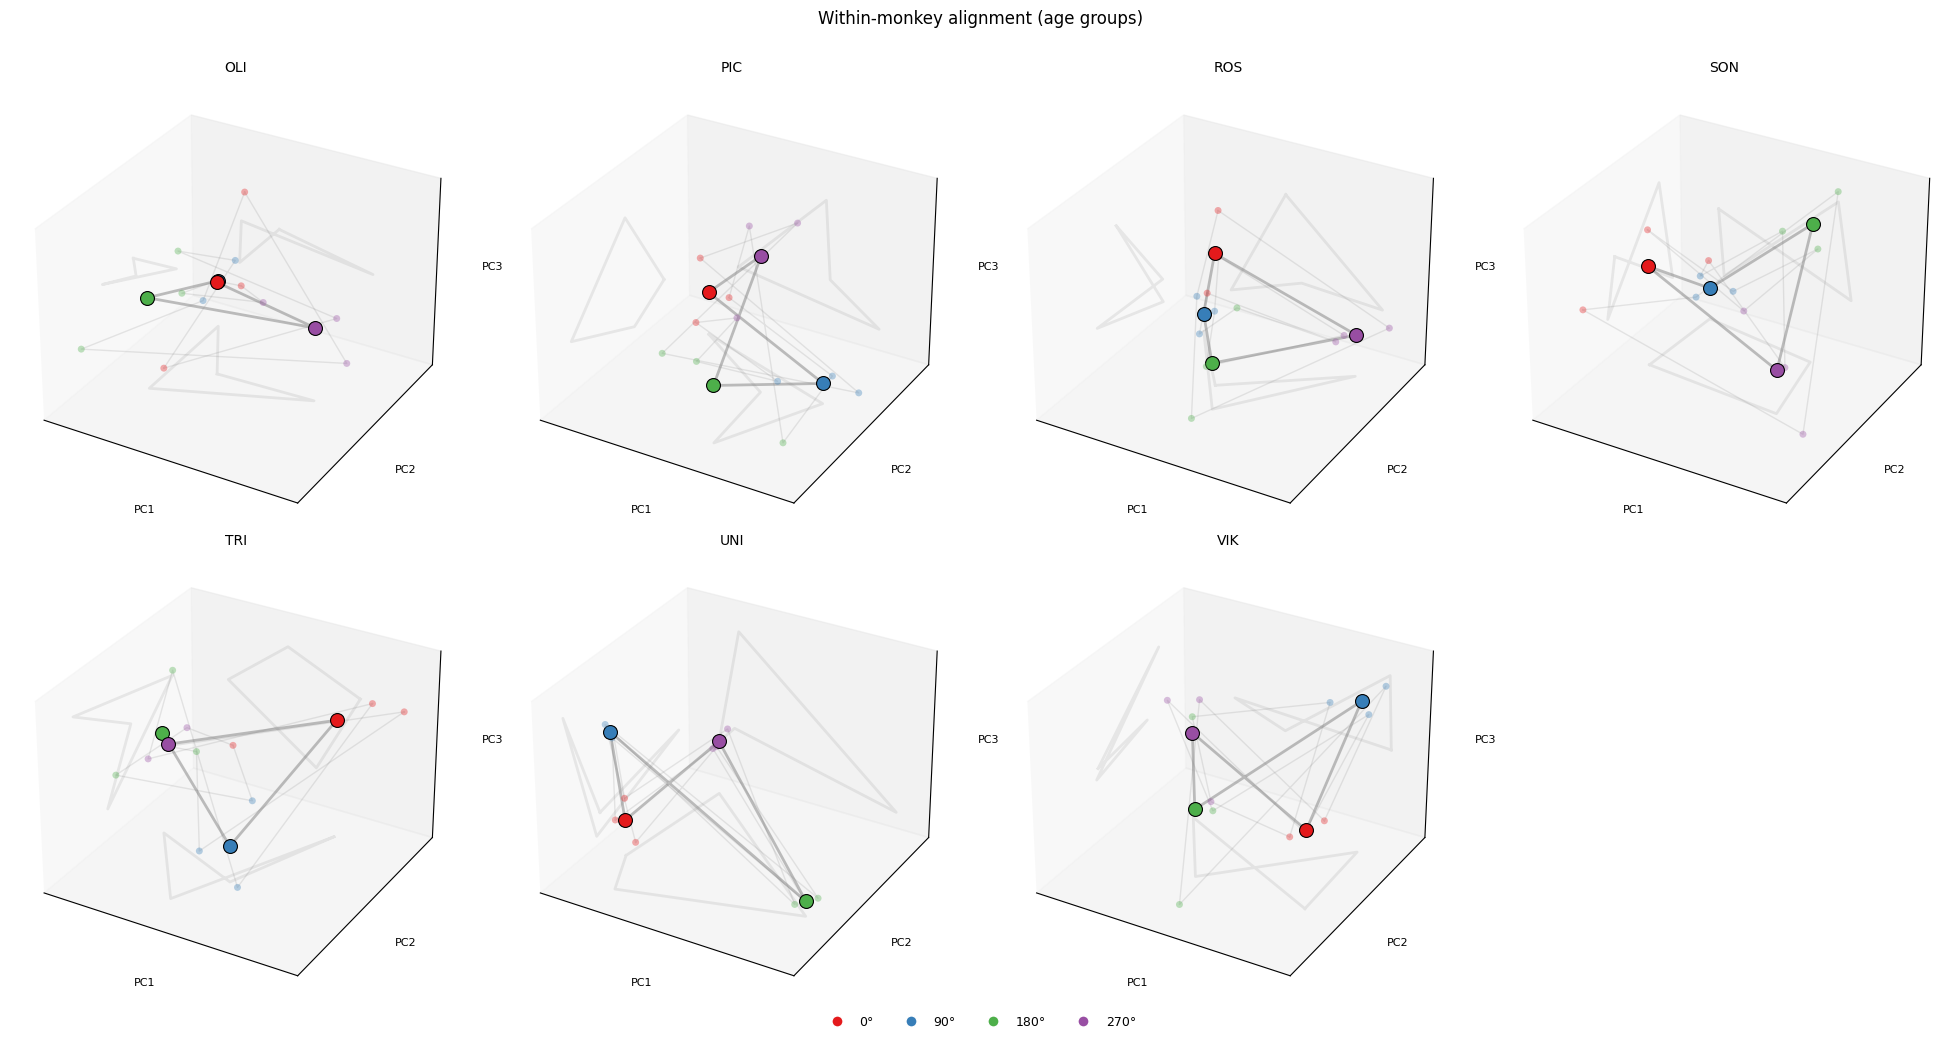

In [6]:
from functions import generalized_procrustes

N_DIMS = 3
n_conds = 4
n_epochs = len(COMMON_EPOCHS)
cue_idx = np.arange(0, n_conds * n_epochs, n_epochs)  # cue-epoch points

AGE_COLORS = ['#1b9e77', '#d95f02', '#7570b3']  # young / middle / old

# ── Within-monkey alignment ──
monkeys_with_multi = [m for m in reduced if len(reduced[m]) > 1]
ncols = min(len(monkeys_with_multi), 4)
nrows = int(np.ceil(len(monkeys_with_multi) / ncols))
fig = plt.figure(figsize=(5 * ncols, 5 * nrows))

for idx, mid in enumerate(monkeys_with_multi):
    groups_dict = reduced[mid]
    group_ids = sorted(groups_dict.keys())
    mats = [tuning_to_matrix(groups_dict[g], N_DIMS) for g in group_ids]

    aligned, mean = generalized_procrustes(mats)

    ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')

    # Individual age groups: smaller, semi-transparent
    for k, g in enumerate(group_ids):
        pts_cue = aligned[k][cue_idx]
        plot_3d_representation(ax, pts_cue, STIM_COLORS, s=25, alpha=0.35, lw=1, edge='none')

    # Mean: large circles
    mean_cue = mean[cue_idx]
    plot_3d_representation(ax, mean_cue, STIM_COLORS, s=100, alpha=1.0, lw=2, edge='k', ew=0.8)
    wall_projections(ax, mean_cue)

    ax.set_title(mid, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel('PC1', fontsize=8)
    ax.set_ylabel('PC2', fontsize=8)
    ax.set_zlabel('PC3', fontsize=8)

# Legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=8, label=l) for c, l in zip(STIM_COLORS, STIM_LABELS)]
fig.legend(handles=handles, loc='lower center', ncol=4, fontsize=9,
           frameon=False, bbox_to_anchor=(0.5, -0.02))
fig.suptitle('Within-monkey alignment (age groups)', fontsize=12, y=1.01)
plt.tight_layout()

## 5. Global alignment (all monkey x age groups)

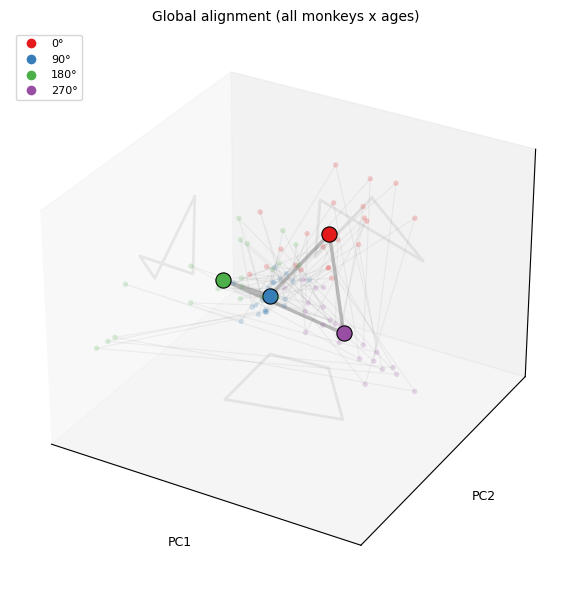

In [7]:
# Collect ALL representations
all_mats = []
all_labels = []
for mid, groups_dict in reduced.items():
    for g, info in sorted(groups_dict.items()):
        all_mats.append(tuning_to_matrix(info, N_DIMS))
        all_labels.append({'monkey': mid, 'group': g})

aligned_all, grand_mean = generalized_procrustes(all_mats)

# ── 3-D plot ──
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Individual representations: small dots + thin connections
for k in range(len(aligned_all)):
    pts_cue = aligned_all[k][cue_idx]
    plot_3d_representation(ax, pts_cue, STIM_COLORS, s=15, alpha=0.2, lw=0.8, edge='none')

# Grand mean: large circles + thick connection
mean_cue = grand_mean[cue_idx]
plot_3d_representation(ax, mean_cue, STIM_COLORS, s=120, alpha=1.0, lw=2.5, edge='k', ew=0.8)
wall_projections(ax, mean_cue)

ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_xlabel('PC1', fontsize=9)
ax.set_ylabel('PC2', fontsize=9)
ax.set_zlabel('PC3', fontsize=9)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=8, label=l) for c, l in zip(STIM_COLORS, STIM_LABELS)]
ax.legend(handles=handles, fontsize=8, loc='upper left')
ax.set_title('Global alignment (all monkeys x ages)', fontsize=10)
plt.tight_layout()

## 6. Within-monkey alignment – delay epoch

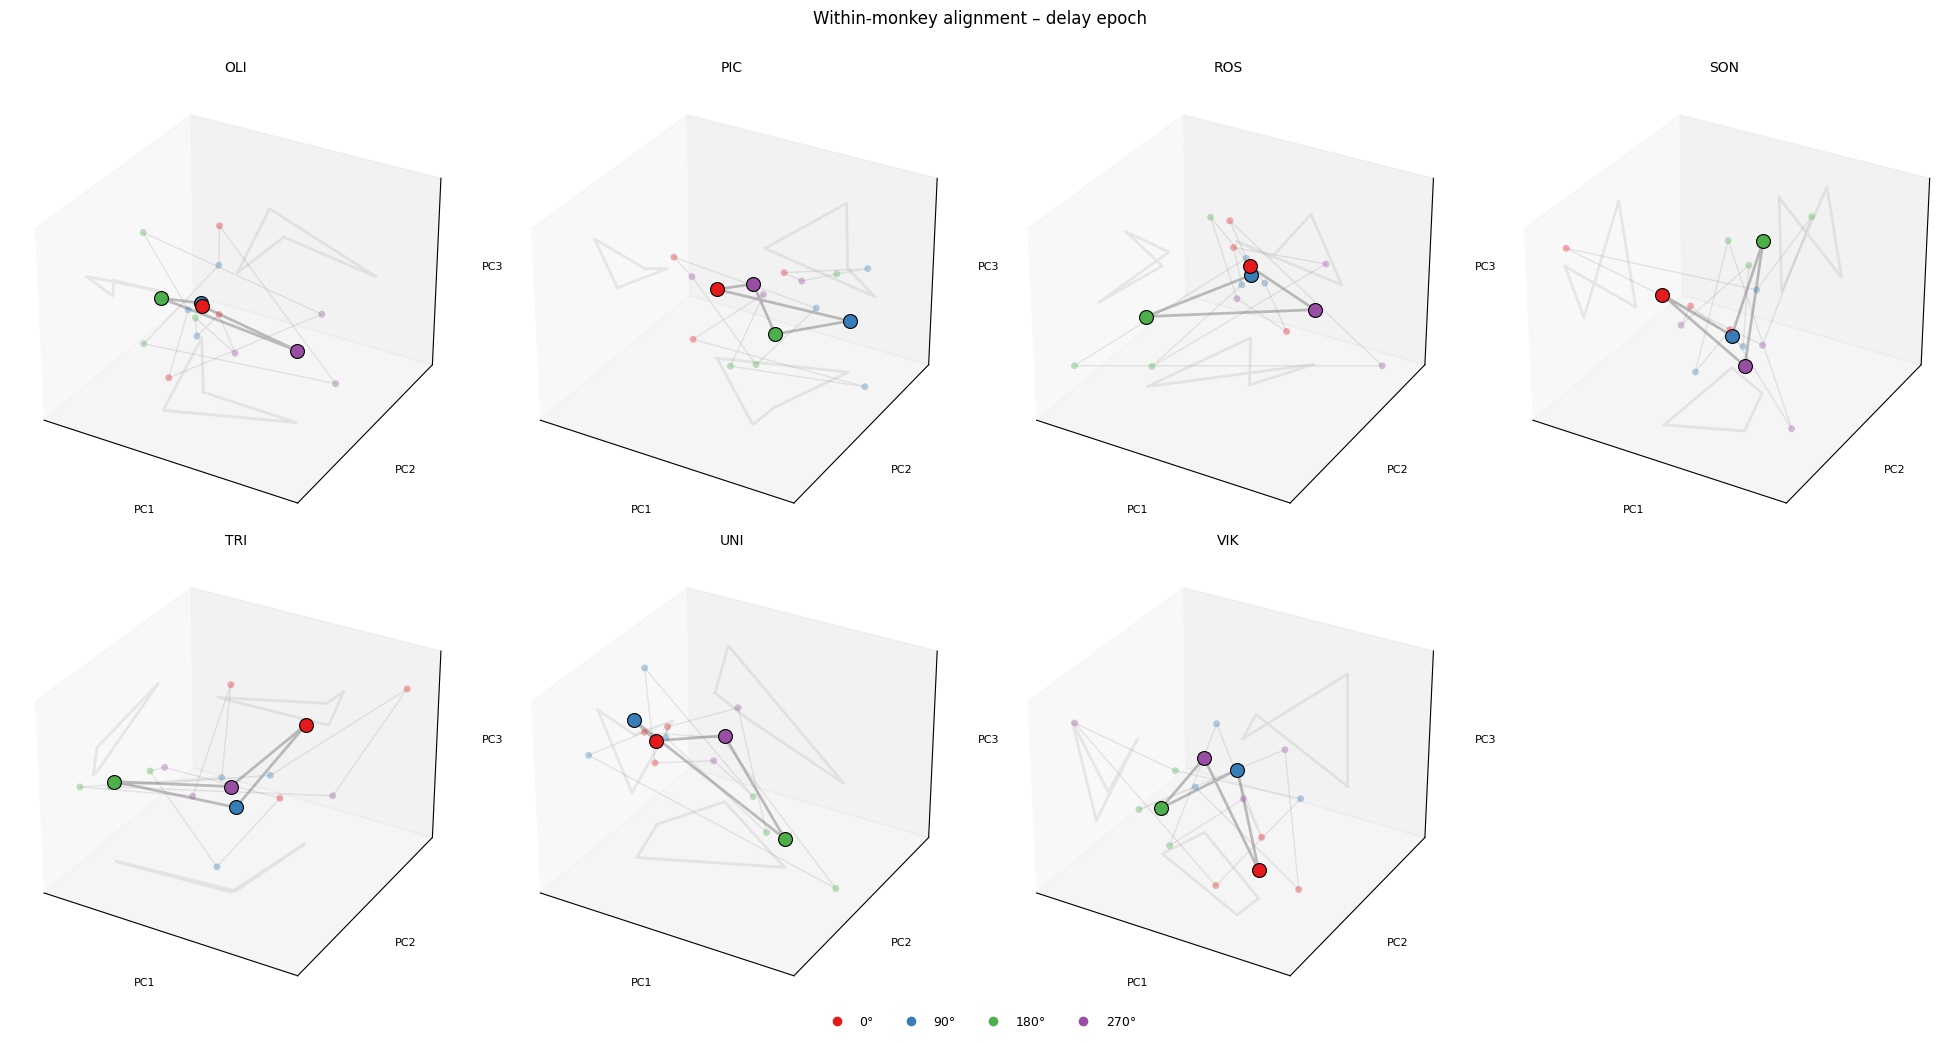

In [8]:
delay_idx = np.arange(1, n_conds * n_epochs, n_epochs)  # [1, 3, 5, 7]

fig = plt.figure(figsize=(5 * ncols, 5 * nrows))

for idx, mid in enumerate(monkeys_with_multi):
    groups_dict = reduced[mid]
    group_ids = sorted(groups_dict.keys())
    mats = [tuning_to_matrix(groups_dict[g], N_DIMS) for g in group_ids]

    aligned, mean = generalized_procrustes(mats)

    ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')

    for k, g in enumerate(group_ids):
        pts_delay = aligned[k][delay_idx]
        plot_3d_representation(ax, pts_delay, STIM_COLORS, s=25, alpha=0.35, lw=1, edge='none')

    mean_delay = mean[delay_idx]
    plot_3d_representation(ax, mean_delay, STIM_COLORS, s=100, alpha=1.0, lw=2, edge='k', ew=0.8)
    wall_projections(ax, mean_delay)

    ax.set_title(mid, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel('PC1', fontsize=8)
    ax.set_ylabel('PC2', fontsize=8)
    ax.set_zlabel('PC3', fontsize=8)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=8, label=l) for c, l in zip(STIM_COLORS, STIM_LABELS)]
fig.legend(handles=handles, loc='lower center', ncol=4, fontsize=9,
           frameon=False, bbox_to_anchor=(0.5, -0.02))
fig.suptitle('Within-monkey alignment – delay epoch', fontsize=12, y=1.01)
plt.tight_layout()

## 7. Global alignment – delay epoch

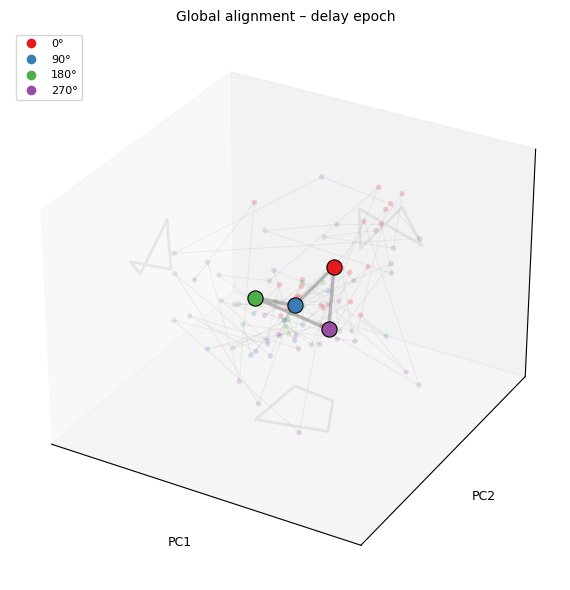

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Individual representations
for k in range(len(aligned_all)):
    pts_delay = aligned_all[k][delay_idx]
    plot_3d_representation(ax, pts_delay, STIM_COLORS, s=15, alpha=0.2, lw=0.8, edge='none')

# Grand mean
mean_delay = grand_mean[delay_idx]
plot_3d_representation(ax, mean_delay, STIM_COLORS, s=120, alpha=1.0, lw=2.5, edge='k', ew=0.8)
wall_projections(ax, mean_delay)

ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_xlabel('PC1', fontsize=9)
ax.set_ylabel('PC2', fontsize=9)
ax.set_zlabel('PC3', fontsize=9)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=8, label=l) for c, l in zip(STIM_COLORS, STIM_LABELS)]
ax.legend(handles=handles, fontsize=8, loc='upper left')
ax.set_title('Global alignment – delay epoch', fontsize=10)
plt.tight_layout()